In [1]:
import copy
from collections import OrderedDict
from datetime import time

import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
class TrainedModel:
    # trains the model and figures out the best value for the parameter
    def __init__(self, dataset):
        # initilaize decision tree model
        self.clf = DecisionTreeClassifier()
        # spilit train dataset into features and labels withoug affecting original dataset
        [x_train, y_train] = copy.deepcopy(dataset)
        # 5 possible pre-determined values
        self.class_mapping = {
            "event": 0,
            "executive_time": 1,
            "lunch": 2,
            "meeting": 3,
            "travel": 4,
        }
        # class number for positive labels
        self.pos = self.class_mapping['executive_time']
        # inverse dictionary to be used for getting original context from class number
        self.inverse = dict(zip(self.class_mapping.values(), self.class_mapping.keys()))
        # convert context values of dataset to class numbers
        for i in range(len(x_train)):
            for j in range(3):
                x_train[i][j] = self.class_mapping[x_train[i][j]]
            y_train[i] = self.class_mapping[y_train[i]]
        # train model
        self.clf = self.clf.fit(x_train, y_train)

    def predict_one(self, top_category_0901, top_category_1101, top_category_1301):
        # get class number for context of each top categories
        top_category_0901 = self.class_mapping[top_category_0901]
        top_category_1101 = self.class_mapping[top_category_1101]
        top_category_1301 = self.class_mapping[top_category_1301]
        # get class number of preditectd top category_1501
        top_category_1501 = self.clf.predict(
            [[top_category_0901, top_category_1101, top_category_1301]]
        )
        # return context value
        return self.inverse[top_category_1501[0]]

    def evaluate_performance(self, dataset):
        # spilit test dataset into features and labels withoug affecting original dataset
        [x_test, y_test] = copy.deepcopy(dataset)
        
        for i in range(len(x_test)):
            # convert context value of test labels to class numbers
            if y_test[i] in self.class_mapping.keys():
                y_test[i] = self.class_mapping[y_test[i]]
            # set all other ones to default(5)
            else:
                y_test[i] = 5
            # convert context value of test features to class numbers
            for j in range(3):
                if x_test[i][j] in self.class_mapping.keys():
                    x_test[i][j] = self.class_mapping[x_test[i][j]]
                # set all other ones to default
                else:
                    x_test[i][j] = 5
        # get class number of predicted 
        y_pred = self.clf.predict(x_test)        
        # weighted performance metric
        weights = []
        for i in range(len(y_pred)):
            if y_test[i] == self.pos or y_pred[i] == self.pos:
                weights.append(1)
            else:
                weights.append(0)

        return metrics.accuracy_score(y_test, y_pred, sample_weight=weights)
        
    def get_confusion_matrix(self, dataset):
        [x_test, y_test] = copy.deepcopy(dataset)

        for i in range(len(x_test)):
            for j in range(3):
                if x_test[i][j] in self.class_mapping.keys():
                    x_test[i][j] = self.class_mapping[x_test[i][j]]
                else:
                    x_test[i][j] = 5

            if y_test[i] in self.class_mapping.keys():
                y_test[i] = self.class_mapping[y_test[i]]
            else:
                y_test[i] = 5

        y_pred = self.clf.predict(x_test)
        # get confusion matrix containing count
        confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
        return confusion_matrix
    
    def visualize(self):
        # plot tree of model
        plot_tree(self.clf)

In [3]:
# read excel file to pandas dataframe
df = pd.read_excel(
        "President Donald Trump Private Schedules, Nov. 7, 2018 to Feb. 2, 2019.xlsx",
        index_col="date",
    )
# get dates of dataset
dates = list(OrderedDict.fromkeys(df.index.tolist()))
# initialize list for dates which has no data
no_data_dates = []
(
    top_categories_0901,
    top_categories_1101,
    top_categories_1301,
    top_categories_1501,
) = ([], [], [], [])

for date in dates:
    cols = df.loc[date]
    top_category_0901, top_category_1101, top_category_1301, top_category_1501 = (
        None,
        None,
        None,
        None,
    )
    
    if len(cols.shape) == 1:
        # dates which has no data
        if cols["top_category"] == "no_data":
            no_data_dates.append(date)
            continue
        # dates which has only one column in original dataset
        else:
            time_starts = [cols["time_start"]]
            time_ends = [cols["time_end"]]
            top_categories = [cols["top_category"]]
    else:
        time_starts = cols["time_start"].tolist()
        time_ends = cols["time_end"].tolist()
        top_categories = cols["top_category"].tolist()

    for time_start, time_end, top_category in zip(
        time_starts, time_ends, top_categories
    ):
        if time_start < time(9, 1) < time_end:
            top_category_0901 = top_category
        if time_start < time(11, 1) < time_end:
            top_category_1101 = top_category
        if time_start < time(13, 1) < time_end:
            top_category_1301 = top_category
        if time_start < time(15, 1) < time_end:
            top_category_1501 = top_category

    top_categories_0901.append(top_category_0901)
    top_categories_1101.append(top_category_1101)
    top_categories_1301.append(top_category_1301)
    top_categories_1501.append(top_category_1501)

dates = [i for i in dates if i not in no_data_dates]
# get preprocessed dataset
df = pd.DataFrame(
    data={
        "top_category_0901": top_categories_0901,
        "top_category_1101": top_categories_1101,
        "top_category_1301": top_categories_1301,
        "top_category_1501": top_categories_1501,
    },
    index=dates,
)
# save preprocessed dataset to csv file
df.to_csv("top_categories.csv")

In [4]:
# drop columns which has non values
df = df.dropna(how="any")
# get features
x = df[
    ["top_category_0901", "top_category_1101", "top_category_1301"]
].values.tolist()
# get labels
y = df["top_category_1501"].tolist()

In [5]:
# get number of positive labels
print('pos: ', y.count('executive_time'))

pos:  23


In [6]:
# get number of negative labels
print('neg: ', len(y)-y.count('executive_time'))

neg:  23


In [7]:
# split dataset to train dataset and test dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
# get trained model
trained_model_A = TrainedModel([x_train, y_train])
# calculate performance
performance = trained_model_A.evaluate_performance([x_test, y_test])
performance

0.5

In [8]:
# get confusion matrix
confusion_matrix = trained_model_A.get_confusion_matrix([x_test, y_test])
print(confusion_matrix)
pd.DataFrame(confusion_matrix)

[[5 2]
 [3 0]]


,0,1
0,5,2
1,3,0


In [9]:
# teest predict function
trained_model_A.predict_one('executive_time', 'meeting', 'lunch')

'executive_time'

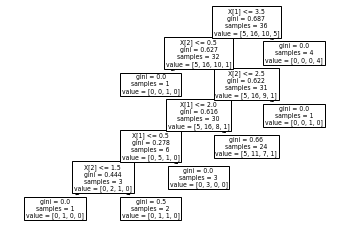

In [11]:
# plot tree of model
trained_model_A.visualize()